## This is a project to comapare different state of the art GANs

This notebook is inspired by [Generative Adverserail Networks(GANS](https://www.coursera.org/specializations/generative-adversarial-networks-gans) by Deeplearnig.ai

In [45]:
import os
import torch
import torchvision
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
from torchvision.utils import save_image
import time

### Getting the data

#### The images are normalised to Mean 0 and Standard deviation as 1. 

This is done for stability reasons. As Generators in GANs usually take a tanh() activation function in the final layer, rescaling the images to the same range would give the Discriminator equal real and fake input data
(suggested in [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160) )

In [46]:
dataset= FashionMNIST(root= 'data', 
               train=True, 
               download=True,
               transform= Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


#### Shape of Images and Length of the Dataset

In [47]:
img=dataset[0][0]
print(img.shape)

print(len(dataset))

torch.Size([1, 28, 28])
60000


#### Creating batches of DATA

In [48]:
batch_size= 100
dataset_real_dl= DataLoader(dataset=dataset, 
                            batch_size=batch_size, 
                            shuffle=True)


#### Denormalising the image to view it!

In [49]:
def denorm(img):
    denorm_img=(img+1)/2
    
    return denorm_img


#### Visualising the DATA

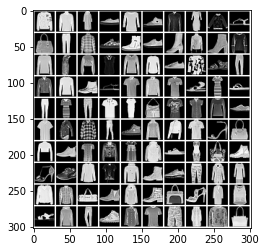

In [50]:
from torchvision.utils import make_grid, save_image

#Function display the generated images
def display_imgs(imgs):
    grid= make_grid(denorm(imgs.detach()), nrow=10, pad_value=2)
    plt.imshow(grid.clamp(0,1).permute(1,2,0))
    plt.show()
    
for imgs, lables in dataset_real_dl:
    display_imgs(imgs)
    break
samples_dir='samples/'
imgs_name='real_images.png'
save_image(denorm(imgs), samples_dir+imgs_name, nrow=10)

#### Initialising the parameters for model architecture

In [51]:
r_size= 64                                    #random vector(latent vector) size
hidden_size= [128*(2**i) for i in range(3)]   #hidden layers sizes
in_size= 28*28                                #input data size
out_size= 1                                   #output of the discriminator
rand_vect_std= torch.randn(batch_size, r_size)#a standard randomvector to compare the generated images

G_layers=[]                                   
G_layers.append(r_size)
for h in hidden_size:
    G_layers.append(h)
G_layers.append(in_size)

D_layers= []
D_layers.append(in_size)
for h in hidden_size[::-1]:
    D_layers.append(h)
D_layers.append(out_size)


In [52]:
# Generator class
class Generator(nn.Module):
    def __init__(self, G_layers):
        super().__init__()
        self.G_layers= G_layers
        self.G_model_list= []
        for i, (in_size, out_size) in enumerate(zip(self.G_layers, self.G_layers[1:])):
            if i<len(self.G_layers)-2:
                self.G_model_list.append(self.getG_Layer(in_size, out_size))
            else:
                self.G_model_list.append(self.getG_Layer(in_size, out_size, final_layer= True))
        self.G_model= nn.Sequential(*self.G_model_list)
                
    def getG_Layer(self,in_size, out_size, final_layer= False):
        if not final_layer:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.ReLU())
        else:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.Tanh())
        return model
    def forward(self, rand_vect):
        fake_img= self.G_model(rand_vect)
        return fake_img.view(-1, 1, 28, 28)
    

In [53]:
#Discriminator class
class Discriminator(nn.Module):
    def __init__(self, D_layers, W_Gan= False):
        super().__init__()
        self.D_layers= D_layers
        self.W_Gan= W_Gan
        self.D_model_list= []
        for i, (in_size, out_size) in enumerate(zip(self.D_layers, self.D_layers[1:])):
            if i<len(self.D_layers)-2:
                self.D_model_list.append(self.getD_Layer(in_size, out_size))
            else:
                self.D_model_list.append(self.getD_Layer(in_size, out_size, final_layer= True))
        self.D_model= nn.Sequential(*self.D_model_list)
                
    def getD_Layer(self,in_size, out_size, final_layer= False):
        if not final_layer:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.LeakyReLU(0.2))
        elif self.W_Gan:
            model= nn.Linear(in_size, out_size)           
        else:
            model= nn.Sequential(nn.Linear(in_size, out_size), nn.Sigmoid())
        return model
    def forward(self, img):
        return self.D_model(img.view(-1, self.D_layers[0]))
        

#### Fully connected Neural Network Architecture for Generator and Discriminator


In [54]:
G= Generator(G_layers)
D= Discriminator(D_layers)
print(G)
print(D)

Generator(
  (G_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=784, bias=True)
      (1): Tanh()
    )
  )
)
Discriminator(
  (D_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    

#### Saving the generated images

In [55]:
def getFakeImages(G):
    rand_vect= torch.randn(batch_size, r_size)
    return G(rand_vect)

def save_fake_imgs(G, Gan_type, epoch):
    samples_dir='samples/{:s}/'.format(Gan_type)
    if not os.path.exists(samples_dir):
        os.mkdir(samples_dir)

    fake_imgs= G(rand_vect_std).detach()
    print(fake_imgs.shape)
    fake_imgs_name= 'fake_images-{:0=4d}.png'.format( epoch)
    print('saving fake_image:', fake_imgs_name)
    save_image(denorm(fake_imgs), samples_dir+fake_imgs_name, nrow=10)

#### Plotting Losses

In [115]:
def plot(lossDict, ganType):
    fig = plt.figure(figsize=(10,8))


    plt.plot(lossDict['Epoch'],  lossDict['D_loss'], 'o-',label='D')
    plt.plot(lossDict['Epoch'],  lossDict['G_loss'], 'o-',label='G')

    ax = plt.gca()

    plt.ylabel('Cross-Entropy Loss')
    plt.xlabel('Epochs')
    plt.legend(fontsize=20, ncol=3) 

    plt.title('GANs Loss', pad=12)
    plt.savefig("{}.png".format(ganType))

#### Various formulations for different GANs are listed below:
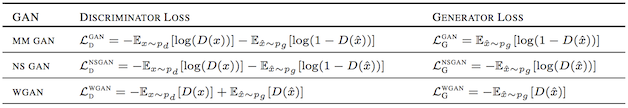

### Original Gan Formulation

In [58]:
def Original_Gan(dataset_real_dl, G_layers, D_layers, epochs=60):

    G= Generator(G_layers)
    D= Discriminator(D_layers)

    Gan_type= 'Original_Gan'

    G_opt= torch.optim.Adam(G.parameters(), lr= 2e-4)
    D_opt= torch.optim.Adam(D.parameters(), lr= 2e-4)
    lossDict= {'S.No':[],'D_loss':[], 'G_loss':[]}

    criterion= nn.BCELoss()
    for epoch in range(epochs):
        D_lossList=[]
        G_lossList=[]
        
        for real_imgs,_ in dataset_real_dl:
            ## Discriminator Training
            fake_imgs= getFakeImages(G)
            #D_loss= -(torch.log(D(real_imgs)).mean() + torch.log(1-D(fake_imgs)).mean())
            D_loss= criterion(D(real_imgs), torch.ones(batch_size,1)) + 
                        criterion(D(fake_imgs), torch.zeros(batch_size,1))
            D_lossList.append(D_loss.item())
            D_opt.zero_grad()
            D_loss.backward()
            D_opt.step()
            
            ##Generator training
            fake_imgs= getFakeImages(G)
            #G_loss= torch.log(1-D(fake_imgs)).mean()
            G_loss= -criterion(D(fake_imgs), torch.zeros(batch_size,1))
            G_lossList.append(G_loss.item())
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        lossDict['S.No'].append(epoch+1)
        lossDict['D_loss'].append(torch.Tensor(D_lossList).mean().item())
        lossDict['G_loss'].append(torch.Tensor(G_lossList).mean().item())
        
        #save_fake_imgs(G, Gan_type, epoch)  
        print('Epoch:{}, D_loss:{:.4f}, G_loss:{:.4f}'.format(epoch, D_loss, G_loss))
    display_imgs(getFakeImages(G))
    torch.save(G.state_dict(), 'G_Original.ckpt')
    torch.save(D.state_dict(), 'D_Original.ckpt')
    
    return lossDict
   
        

In [59]:
OrgGan_loss= Original_Gan(dataset_real_dl, G_layers, D_layers, 30)


Epoch:0, D_loss:0.0000, G_loss:-0.0000
Epoch:1, D_loss:0.0000, G_loss:-0.0000


KeyboardInterrupt: 

### Nonsaturating Game formulation

In [70]:
#Training non-saturating formulation
def NonSaturating_Gan(dataset_real_dl, G_layers, D_layers, epochs=60):

    G= Generator(G_layers)
    G.load_state_dict(torch.load('G_NonSaturating.ckpt'))
    
    D= Discriminator(D_layers)
    D.load_state_dict(torch.load('D_NonSaturating.ckpt'))

    Gan_type= 'NonSaturating_Gan'
    

    G_opt= torch.optim.Adam(G.parameters(), lr= 2e-4)
    D_opt= torch.optim.Adam(D.parameters(), lr= 2e-4)
    
    criterion= nn.BCELoss()
    lossDict= {'Epochs':[],'D_loss':[], 'G_loss':[]}
    
    for epoch in range(epochs):
        D_lossCum=0
        G_lossCum=0
        for real_imgs,_ in dataset_real_dl:
            ## Discriminator Training
            fake_imgs= getFakeImages(G)
            #D_loss= -(torch.log(D(real_imgs)).mean() + torch.log(1-D(fake_imgs)).mean())
            D_loss= criterion(D(real_imgs), torch.ones(batch_size,1)) + 
                        criterion(D(fake_imgs), torch.zeros(batch_size,1))
            D_lossCum+=D_loss.item()
            D_opt.zero_grad()
            D_loss.backward()
            D_opt.step()
            
            ##Generator training
            fake_imgs= getFakeImages(G)
            #G_loss= -torch.log(D(fake_imgs)).mean()
            G_loss= criterion(D(fake_imgs), torch.ones(batch_size,1))
            G_lossCum+=G_loss.item()
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        lossDict['S.No'].append(epoch+31)
        lossDict['D_loss'].append(D_lossCum/batch_size)
        lossDict['G_loss'].append(G_lossCum/batch_size)
        #save_fake_imgs(G, Gan_type, epoch)  
        print('Epoch:{}, D_loss:{:.4f}, G_loss:{:.4f}'.format(epoch, D_loss, G_loss))
    display_imgs(getFakeImages(G))
    torch.save(G.state_dict(), 'G_NonSaturating.ckpt')
    torch.save(D.state_dict(), 'D_NonSaturating.ckpt')
    return lossDict
        

Epoch:0, D_loss:0.8609, G_loss:2.8075
Epoch:1, D_loss:0.6885, G_loss:2.0662
Epoch:2, D_loss:0.5452, G_loss:2.5618
Epoch:3, D_loss:0.3142, G_loss:3.1033
Epoch:4, D_loss:0.5921, G_loss:2.3127
Epoch:5, D_loss:0.6965, G_loss:2.2719
Epoch:6, D_loss:0.6114, G_loss:2.5304
Epoch:7, D_loss:0.5495, G_loss:2.4002
Epoch:8, D_loss:0.7917, G_loss:2.0282
Epoch:9, D_loss:0.6087, G_loss:2.2995
Epoch:10, D_loss:0.4746, G_loss:2.4589
Epoch:11, D_loss:0.4141, G_loss:2.8518
Epoch:12, D_loss:0.5914, G_loss:2.1256
Epoch:13, D_loss:0.6217, G_loss:2.7552
Epoch:14, D_loss:0.5630, G_loss:2.3734
Epoch:15, D_loss:0.5138, G_loss:2.1758
Epoch:16, D_loss:0.7064, G_loss:2.6799
Epoch:17, D_loss:0.5941, G_loss:2.8544
Epoch:18, D_loss:0.7650, G_loss:3.0705
Epoch:19, D_loss:0.4214, G_loss:3.1432
Epoch:20, D_loss:0.5677, G_loss:2.9023
Epoch:21, D_loss:0.4472, G_loss:2.2374
Epoch:22, D_loss:0.6147, G_loss:1.8746
Epoch:23, D_loss:0.8615, G_loss:2.6556
Epoch:24, D_loss:0.5697, G_loss:2.4078
Epoch:25, D_loss:0.7421, G_loss:2.4

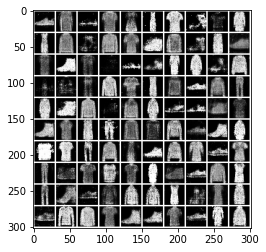

In [71]:
NSGan_loss=NonSaturating_Gan(dataset_real_dl, G_layers, D_layers, 60)

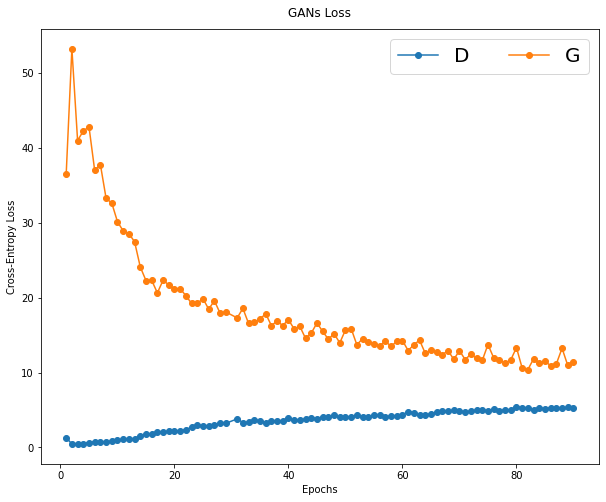

In [114]:
plot(NSGan_loss,"nsGAN")

### Wasserstein Gan 

In [100]:
#Training Wasserstein Gan formulation
def WStein_Gan(dataset_real_dl, G_layers, D_layers, epochs=60):

    G= Generator(G_layers)
    D= Discriminator(D_layers, W_Gan=True)
    
    D_iterations= 5
    Weight_clip= 0.01
    Gan_type= 'WStein_Gan'

    G_opt= torch.optim.RMSprop(G.parameters(), lr= 2e-4)
    D_opt= torch.optim.RMSprop(D.parameters(), lr= 2e-4)
    
    lossDict= {'Epoch':[],'D_loss':[], 'G_loss':[]}
    
    for epoch in range(epochs):
        D_lossCum=0
        G_lossCum=0
        for real_imgs,_ in dataset_real_dl:
            ## Discriminator Training
            for i in range(D_iterations):
                fake_imgs= getFakeImages(G)
                D_loss= -(D(real_imgs).mean() - D(fake_imgs).mean())
                D_lossCum+=D_loss.item()
                D_opt.zero_grad()
                D_loss.backward(retain_graph= True)
                D_opt.step()
                ## Clamping weights [-0.01, 0.01]
                for weight in D.parameters():
                    weight.detach().clamp_(-Weight_clip, Weight_clip)
            #D_lossCum=D_lossCum/D_iterations
            
            ##Generator training
            fake_imgs= getFakeImages(G)
            G_loss= -D(fake_imgs).mean()
            G_lossCum+=G_loss.item()
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        lossDict['Epoch'].append(epoch+1)
        lossDict['D_loss'].append(D_lossCum/batch_size)
        lossDict['G_loss'].append(G_lossCum/batch_size)
        #save_fake_imgs(G, Gan_type, epoch)  
        print('Epoch:{}, D_loss:{:.4f}, G_loss:{:.4f}'.format(epoch, D_loss, G_loss))
    display_imgs(getFakeImages(G))
    torch.save(G.state_dict(), 'G_WGan.ckpt')
    torch.save(D.state_dict(), 'D_WGan.ckpt')
    plot(lossDict, Gan_type)
    
    return lossDict
   
        

Epoch:0, D_loss:-1.1948, G_loss:-0.4713
Epoch:1, D_loss:-0.6028, G_loss:0.3114
Epoch:2, D_loss:-0.5175, G_loss:-0.4632
Epoch:3, D_loss:-0.4698, G_loss:-0.0689
Epoch:4, D_loss:-0.4059, G_loss:-0.0682
Epoch:5, D_loss:-0.4520, G_loss:0.9905
Epoch:6, D_loss:-0.5006, G_loss:-0.5260
Epoch:7, D_loss:-0.4031, G_loss:0.2010
Epoch:8, D_loss:-0.2847, G_loss:0.6327
Epoch:9, D_loss:-0.5325, G_loss:0.6775
Epoch:10, D_loss:-0.3114, G_loss:-0.2167
Epoch:11, D_loss:-0.4380, G_loss:-0.4940
Epoch:12, D_loss:-0.2311, G_loss:-1.8754
Epoch:13, D_loss:-0.2029, G_loss:0.7829
Epoch:14, D_loss:-0.2390, G_loss:1.0536
Epoch:15, D_loss:-0.1011, G_loss:0.2021
Epoch:16, D_loss:0.0258, G_loss:0.1160
Epoch:17, D_loss:-0.0121, G_loss:0.2045
Epoch:18, D_loss:-0.0859, G_loss:0.3775
Epoch:19, D_loss:0.1294, G_loss:0.5550
Epoch:20, D_loss:0.0073, G_loss:0.1675
Epoch:21, D_loss:-0.0446, G_loss:-0.2496
Epoch:22, D_loss:-0.2035, G_loss:1.0625
Epoch:23, D_loss:-0.2848, G_loss:-2.4281
Epoch:24, D_loss:-0.5822, G_loss:-2.8977
Ep

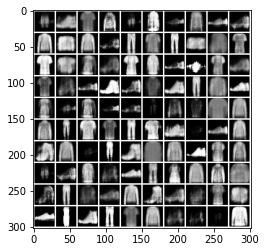

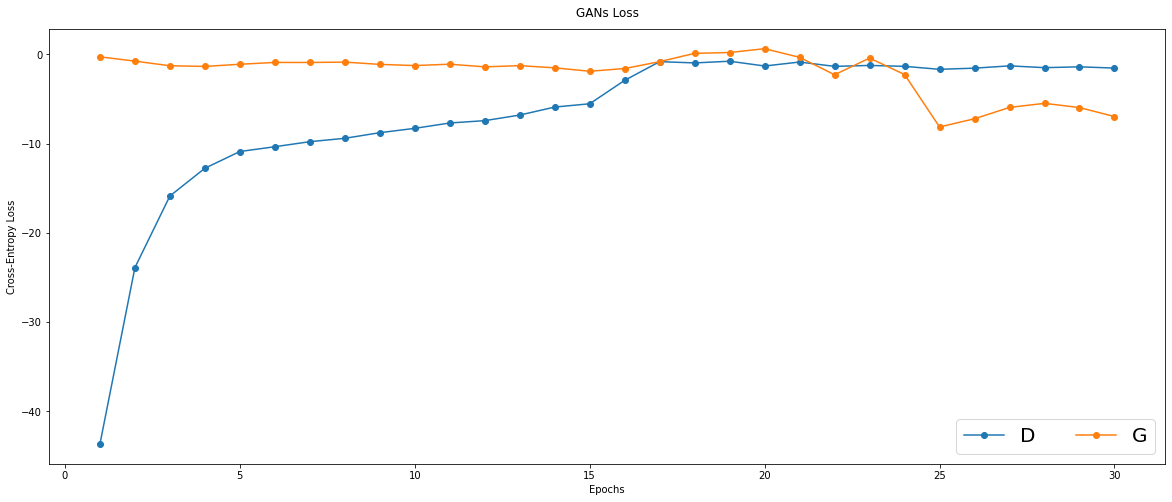

In [102]:
wGan_loss2= WStein_Gan(dataset_real_dl, G_layers, D_layers, 30)


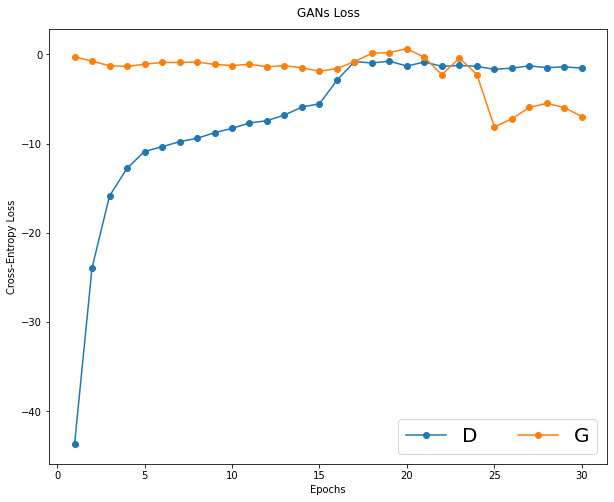

In [111]:
plot(wGan_loss2,'W_Gan')

### Deep Convolutinal GANs
This DC_Gans architecture is inspired by [DC_Gans tutorial in pytorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [36]:
r_size= 100                                    #random vector(latent vector) size
rand_vect_std= torch.randn(batch_size, r_size) #a standard randomvector to compare the generated images

in_channels=1

#### Third attempt to design good DC Gan for MNIST-Fashion Dataset

In [ ]:
class DC_Gen_t3(nn.Module):
    def __init__(self, r_size, in_channels):
        super().__init__()
        self.r_size= r_size
        
        self.model=nn.Sequential(
                # input batch_size x in_channel(r_size=100) x 1 x 1
                nn.ConvTranspose2d(r_size,32,kernel_size=7, stride=1, padding=0, bias=False ), 
                # output batch_size x out_channel(32) x 7 x 7
                nn.BatchNorm2d(32),  
                nn.ReLU(),
                
                # input batch_size x in_channel(32) x 7 x 7
                nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False ),
                # output batch_size x out_channel(16) x 14 x 14
                nn.BatchNorm2d(16),  
                nn.ReLU(),
                
                # input batch_size x in_channel(16) x 14 x 14
                nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, bias=False ),
                # output batch_size x out_channel(1) x 28 x 28
                nn.Tanh())
    
    def forward(self, rand_vect):
        pred= self.model(rand_vect.view(-1, self.r_size, 1, 1))        
        return pred   
        
        
class DC_Disc_t3(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.model= nn.Sequential(
                # input batch_size x in_channel(1) x 28 x 28
                nn.Conv2d(in_channels, 16, kernel_size=4, stride=2, padding=1, bias=False),
                # output batch_size x out_channel(16) x 14 x 14
                nn.BatchNorm2d(16),  
                nn.LeakyReLU(0.2),
                nn.Dropout(0.2),

                # input batch_size x in_channel(16) x 14 x 14
                nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False), 
                # output batch_size x out_channel(32) x 7 x 7
                nn.BatchNorm2d(32),  
                nn.LeakyReLU(0.2),
                nn.Dropout(0.2),
            
                # input batch_size x in_channel(32) x 7 x 7
                nn.Conv2d(32, 1, kernel_size=7, stride=2, padding=0, bias=False ), 
                # output batch_size x out_channel(1) x 1 x 1
                nn.Sigmoid())
        
    def forward(self, img):

        pred= self.model(img)
        return pred  

In [106]:
#Training of DC_Gans
def DC_Gan(dataset_real_dl, epochs=60):

    G= DC_Gen_t3(r_size, in_channels)
#     G.load_state_dict(torch.load('G_DC_t3_FashionMNIST.ckpt'))

    D= DC_Disc_t3(in_channels)
#     D.load_state_dict(torch.load('D_DC_t3_FashionMNIST.ckpt'))
    
    G.train()
    D.train()

    Gan_type= 'DC_Gan'

    G_opt= torch.optim.Adam(G.parameters(), lr= 2e-3)
    D_opt= torch.optim.Adam(D.parameters(), lr= 2e-4)
    
    criterion= nn.BCELoss()
    real_lables= torch.ones(batch_size,in_channels,1,1)
    fake_lables= torch.zeros(batch_size,in_channels,1,1)
    
    lossDict= {'Epoch':[],'D_loss':[], 'G_loss':[]}
    for epoch in range(epochs):
        D_lossCum=0
        G_lossCum=0
        for i, (real_imgs,_) in enumerate(dataset_real_dl):
#             start_time= time.time()

            ## Discriminator Training
            fake_imgs= getFakeImages(G)
            #D_loss= -(torch.log(D(real_imgs)).mean() +torch.log(D(fake_imgs)).mean())
            D_loss= criterion(D(real_imgs),real_lables)  + criterion(D(fake_imgs), fake_lables)
            D_lossCum+=D_loss.item()
            D_opt.zero_grad()
            D_loss.backward()
            D_opt.step()
            
            ##Generator training
            fake_imgs= getFakeImages(G)
            #G_loss= -torch.log(D(fake_imgs)).mean()
            G_loss= criterion(D(fake_imgs), real_lables)
            G_lossCum+=G_loss.item()
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
#             print(i,D_loss)
#             end_time= time.time()
#             print(end_time-start_time)

        #save_fake_imgs(G, Gan_type, epoch)
        print('Epoch:{}, D_loss:{:.4f}, G_loss:{:.4f}'.format(epoch, D_loss, G_loss))
        lossDict['Epoch'].append(epoch+1)
        lossDict['D_loss'].append(D_lossCum/batch_size)
        lossDict['G_loss'].append(G_lossCum/batch_size)
        
    G.eval()
    D.eval()
    display_imgs(getFakeImages(G))
    torch.save(G.state_dict(), 'G_DC_t3_FashionMNIST.ckpt')
    torch.save(D.state_dict(), 'D_DC_t3_FashionMNIST.ckpt')
    
    plot(lossDict, Gan_type)
    
    return lossDict
   
        

In [104]:
G= DC_Gen_t3(r_size, in_channels)
D= DC_Disc_t3(in_channels)
print(D)
print(G)

DC_Disc_t3(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 1, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (9): Sigmoid()
  )
)
DC_Gen_t3(
  (model): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1

Epoch:0, D_loss:1.2121, G_loss:0.9469
Epoch:1, D_loss:1.5418, G_loss:0.6898
Epoch:2, D_loss:1.3418, G_loss:0.7636
Epoch:3, D_loss:1.0383, G_loss:1.0240
Epoch:4, D_loss:1.3202, G_loss:0.9208
Epoch:5, D_loss:1.3665, G_loss:0.8229
Epoch:6, D_loss:1.2716, G_loss:0.8765
Epoch:7, D_loss:1.2257, G_loss:1.0309
Epoch:8, D_loss:1.2233, G_loss:0.9045
Epoch:9, D_loss:1.4628, G_loss:0.8194
Epoch:10, D_loss:1.2844, G_loss:0.8735
Epoch:11, D_loss:1.1302, G_loss:0.8605
Epoch:12, D_loss:1.3143, G_loss:0.9303
Epoch:13, D_loss:1.3104, G_loss:0.8403
Epoch:14, D_loss:1.2528, G_loss:0.8504
Epoch:15, D_loss:1.2808, G_loss:0.8869
Epoch:16, D_loss:1.4235, G_loss:0.8067
Epoch:17, D_loss:1.3510, G_loss:0.8495
Epoch:18, D_loss:1.3409, G_loss:0.8174
Epoch:19, D_loss:1.4637, G_loss:0.8881
Epoch:20, D_loss:1.3811, G_loss:0.7744
Epoch:21, D_loss:1.3509, G_loss:0.7860
Epoch:22, D_loss:1.4693, G_loss:0.8085
Epoch:23, D_loss:1.3301, G_loss:0.8169
Epoch:24, D_loss:1.3055, G_loss:0.8253
Epoch:25, D_loss:1.3870, G_loss:0.7

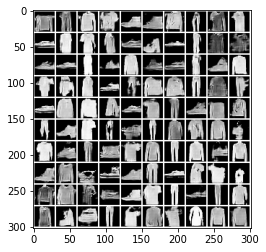

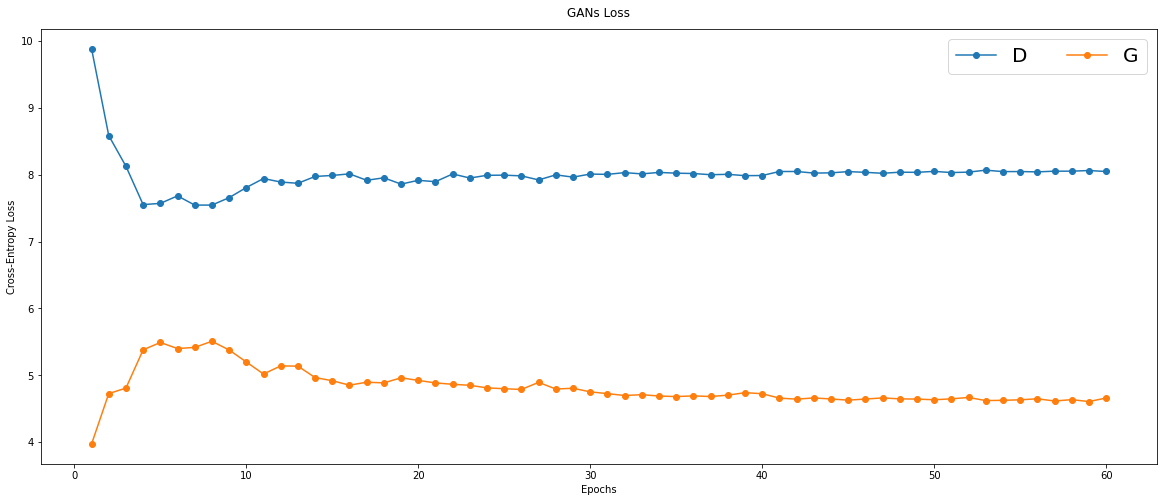

In [107]:
NS_DC_loss=DC_Gan(dataset_real_dl,60)

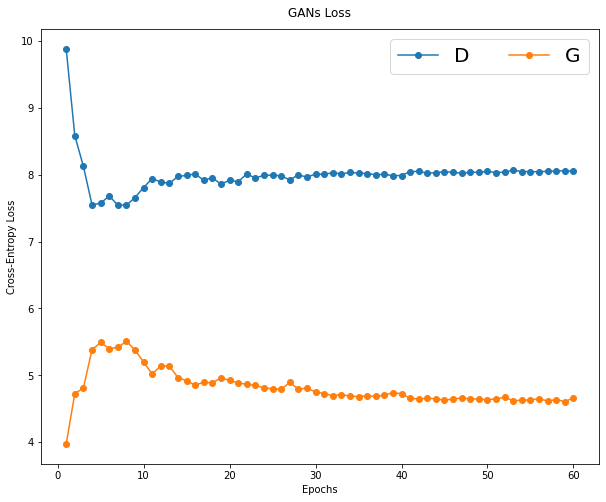

In [109]:
plot(NS_DC_loss, 'DC_Gan')

In [138]:
#Training Wasserstein Gan formulation
def WStein_DC_Gan(dataset_real_dl,epochs=60):

    G= DC_Gen_t3(r_size, in_channels)
    G.load_state_dict(torch.load('G_WGanDc.ckpt'))

    D= DC_Disc_t3(in_channels)
    D.load_state_dict(torch.load('D_WGanDc.ckpt'))

    D_iterations= 3
    Weight_clip= 0.01
    Gan_type= 'WStein_Gan_DC'

    G_opt= torch.optim.Adam(G.parameters(), lr= 2e-4)
    D_opt= torch.optim.Adam(D.parameters(), lr= 2e-4)
    
    lossDict= {'Epoch':[],'D_loss':[], 'G_loss':[]}
    
    for epoch in range(epochs):
        D_lossCum=0
        G_lossCum=0
        for real_imgs,_ in dataset_real_dl:
            ## Discriminator Training
            for i in range(D_iterations):
                fake_imgs= getFakeImages(G)
                D_loss= -(D(real_imgs).mean() - D(fake_imgs).mean())
                D_lossCum+=D_loss.item()
                D_opt.zero_grad()
                D_loss.backward(retain_graph= True)
                D_opt.step()
                ## Clamping weights [-0.01, 0.01]
                for weight in D.parameters():
                    weight.detach().clamp_(-Weight_clip, Weight_clip)
            #D_lossCum=D_lossCum/D_iterations
            
            ##Generator training
            fake_imgs= getFakeImages(G)
            G_loss= -D(fake_imgs).mean()
            G_lossCum+=G_loss.item()
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        lossDict['Epoch'].append(epoch+31)
        lossDict['D_loss'].append(D_lossCum/batch_size)
        lossDict['G_loss'].append(G_lossCum/batch_size)
        #save_fake_imgs(G, Gan_type, epoch)  
        print('Epoch:{}, D_loss:{:.4f}, G_loss:{:.4f}'.format(epoch, D_loss, G_loss))
    display_imgs(getFakeImages(G))
    torch.save(G.state_dict(), 'G_WGan.ckpt')
    torch.save(D.state_dict(), 'D_WGan.ckpt')
    plot(lossDict, Gan_type)
    
    return lossDict
   
        

In [139]:
Wstein_DC_loss2=WStein_DC_Gan(dataset_real_dl,30)

Epoch:0, D_loss:-0.0023, G_loss:-0.4967
Epoch:1, D_loss:-0.0030, G_loss:-0.5002
Epoch:2, D_loss:-0.0011, G_loss:-0.4956
Epoch:3, D_loss:-0.0012, G_loss:-0.4954
Epoch:4, D_loss:-0.0038, G_loss:-0.5010
Epoch:5, D_loss:-0.0003, G_loss:-0.4986
Epoch:6, D_loss:-0.0012, G_loss:-0.4972


KeyboardInterrupt: 

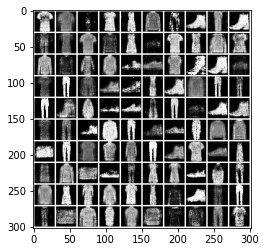

torch.Size([100, 1, 28, 28])
saving fake_image: fake_images-0090.png


In [140]:
r_size= 64                                    #random vector(latent vector) size
G= Generator(G_layers)
G.load_state_dict(torch.load('G_NonSaturating.ckpt'))

display_imgs(getFakeImages(G))
save_fake_imgs(G,'G_NonSaturating', 90)

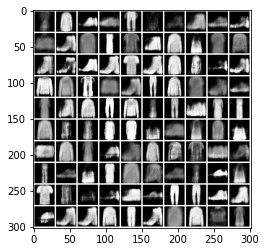

torch.Size([100, 1, 28, 28])
saving fake_image: fake_images-0030.png


In [141]:
G= Generator(G_layers)
G.load_state_dict(torch.load('G_WGan.ckpt'))

display_imgs(getFakeImages(G))
save_fake_imgs(G,'G_WGan', 30)

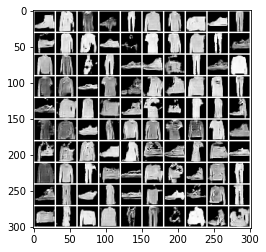

torch.Size([100, 1, 28, 28])
saving fake_image: fake_images-0060.png


In [142]:
G= DC_Gen_t3(r_size, in_channels)
G.load_state_dict(torch.load('G_DC_t3_FashionMNIST.ckpt'))
G.eval()
display_imgs(getFakeImages(G))
save_fake_imgs(G,'G_DC_t3_FashionMNIST', 60)

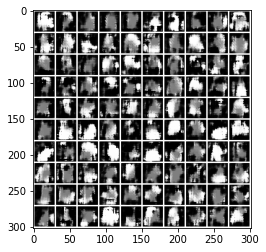

torch.Size([100, 1, 28, 28])
saving fake_image: fake_images-0040.png


In [143]:
G= DC_Gen_t3(r_size, in_channels)
G.load_state_dict(torch.load('G_WGanDc.ckpt'))
G.eval()
display_imgs(getFakeImages(G))
save_fake_imgs(G,'G_WGan', 40)